# Multiclass Food Prediction

By: Arnav Rangwani

Dataset: https://www.kaggle.com/datasets/dansbecker/food-101/data

## Importing the Libraries

In [1]:
import os
from collections import defaultdict
from shutil import copy, copytree, rmtree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image

`images` folder contains 101 folders with 1000 images each of a specific class.

In [2]:
os.listdir("data/food-101/images")

['.DS_Store',
 'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisq

`meta` folder contains `train.txt` which contains the list of images that belongs to the training set, `test.txt` which contains the list of images that belongs to the testing set, `classes.txt` which contains the list of all the classes of food.

In [3]:
os.listdir("data/food-101/meta")

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

## Visualizing a random image from each of the 101 classes

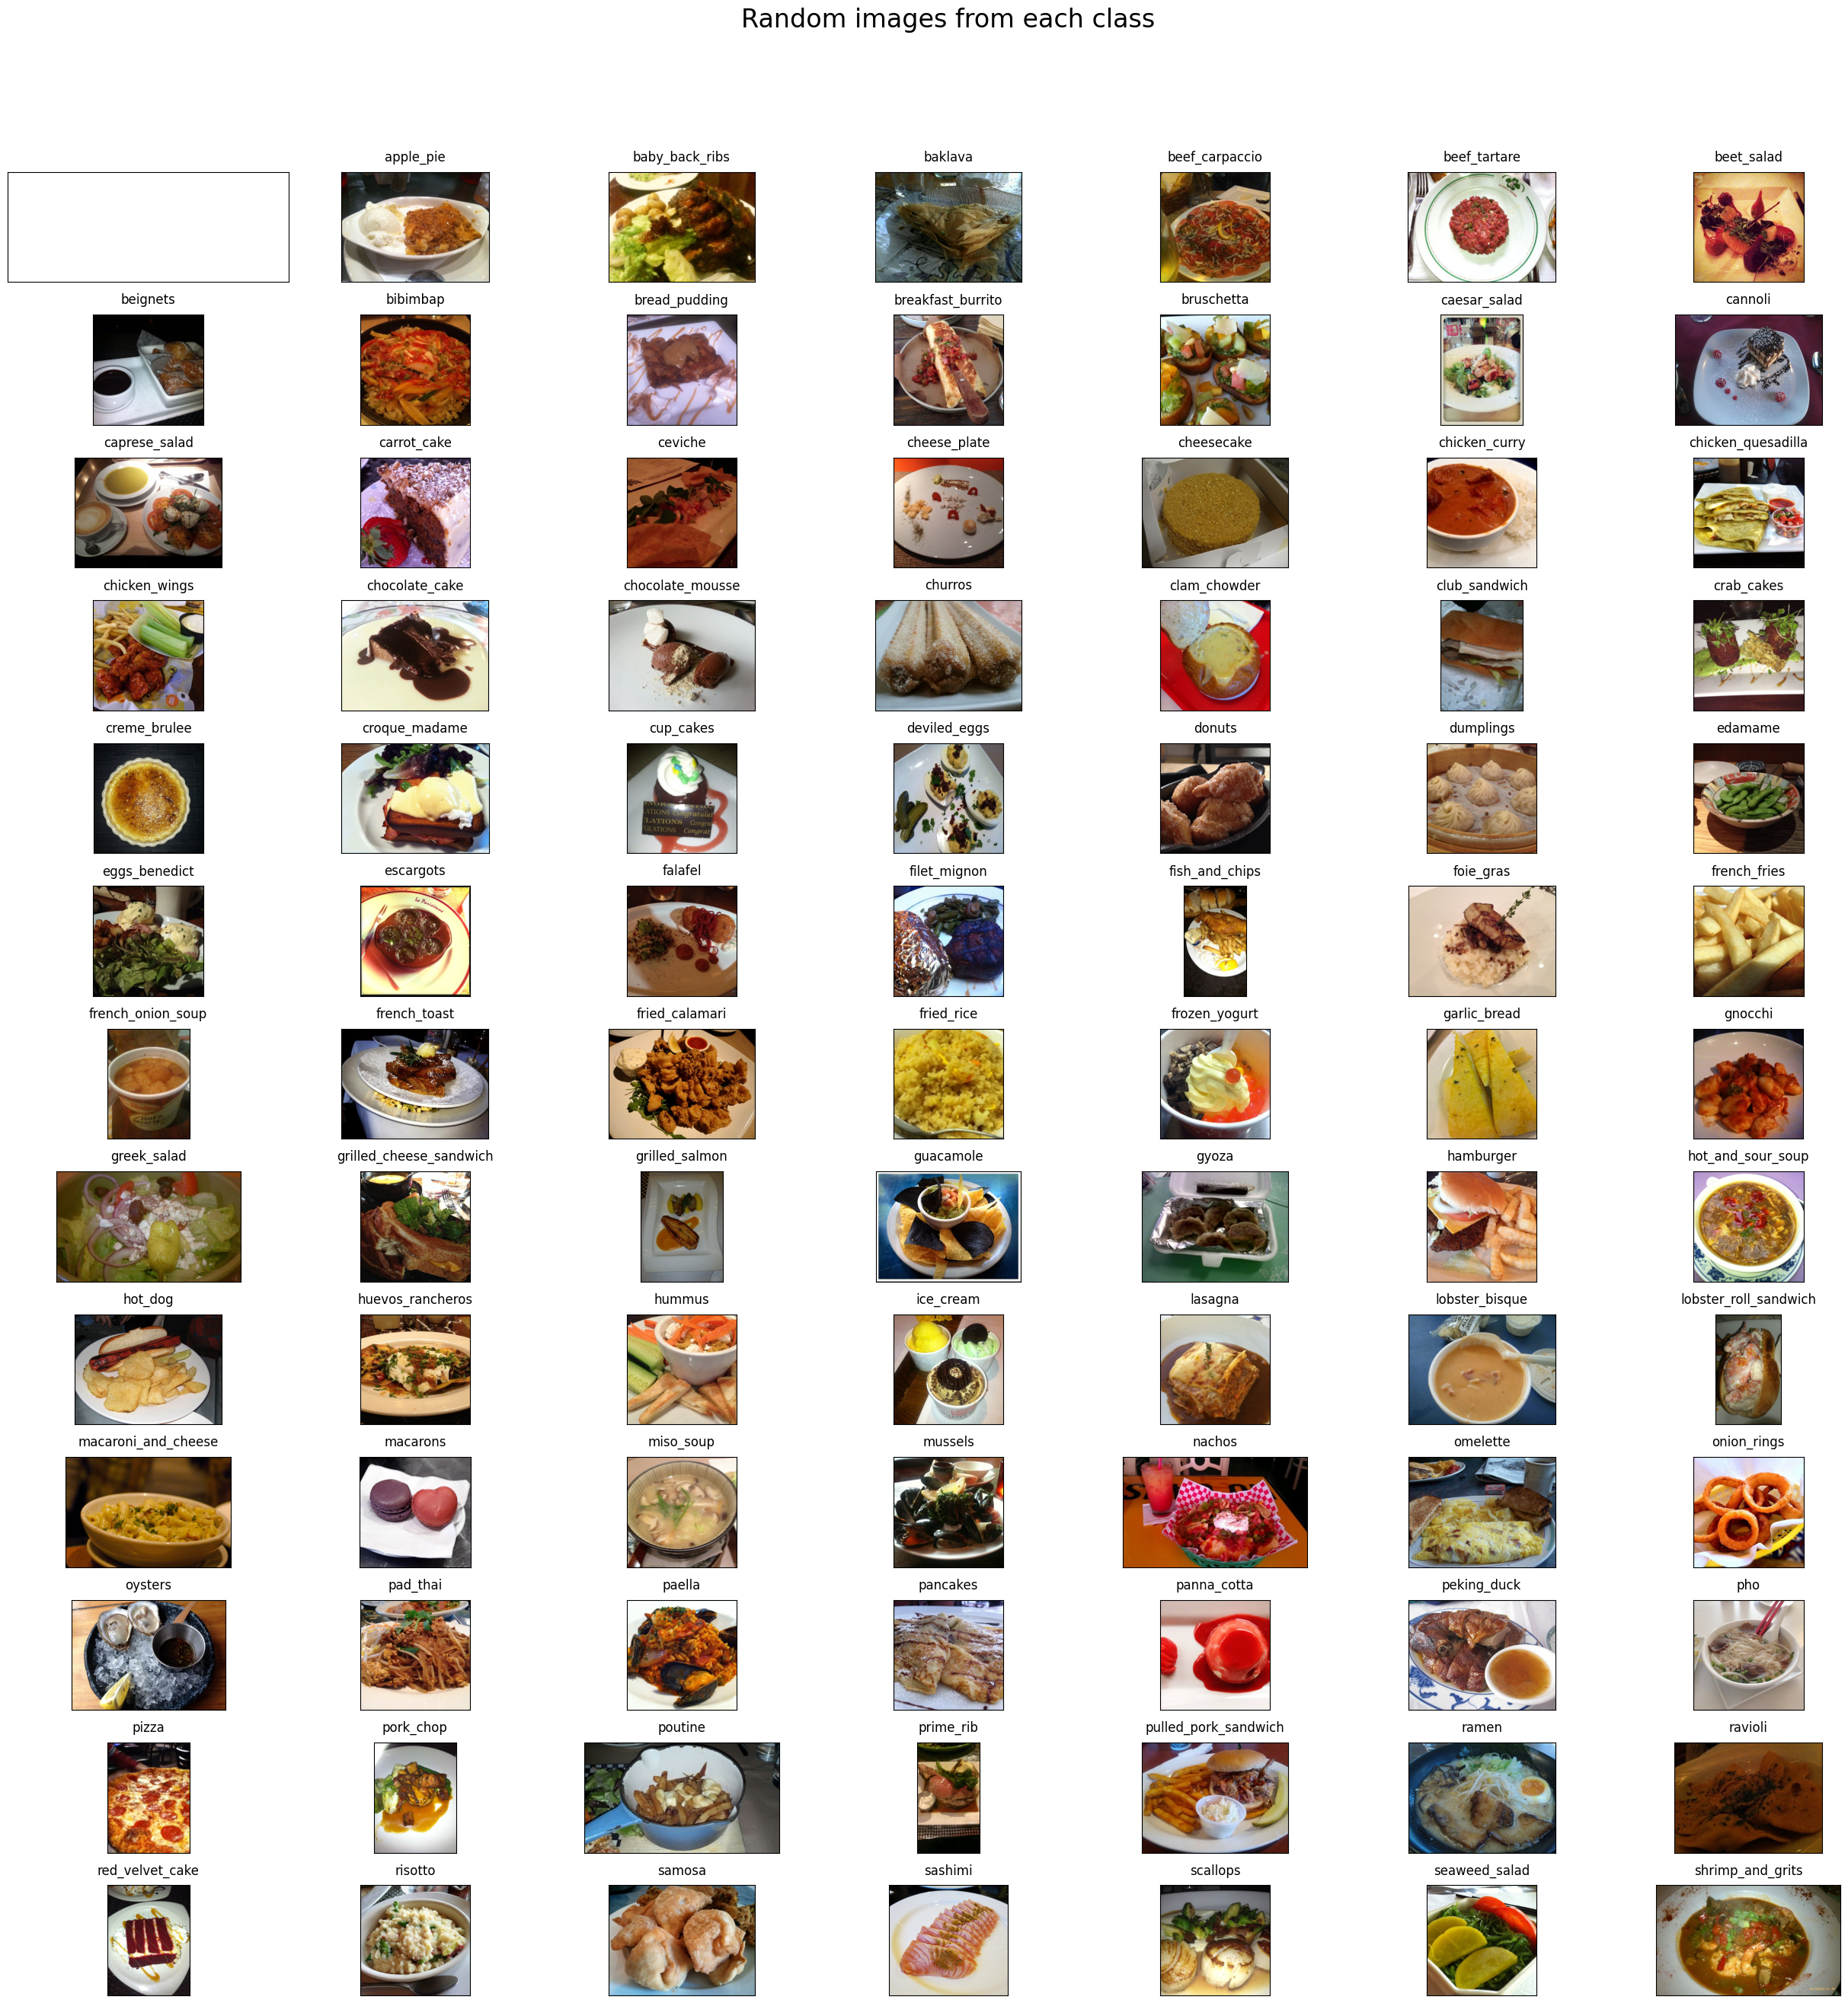

In [4]:
rows = 13
cols = 7
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Random images from each class", y=1.05, fontsize=24)
data_dir = "data/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id] 
            food_id += 1
        except:
            break
        if food_selected == ".DS_Store":
            continue
        food_selected_images = os.listdir(os.path.join(data_dir,food_selected))
        food_selected_random = np.random.choice(food_selected_images)
        img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

## Splitting the images into `train` and `test` using `train.txt` and `test.txt`

In [5]:
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + ".jpg")

    for food in classes_images.keys():
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))

In [6]:
prepare_data("data/food-101/meta/train.txt", "data/food-101/images", "data/train")

In [7]:
dir_path = "data/train"
count = 0
for folder in os.listdir(dir_path):
    for f in os.listdir(f"{dir_path}/{folder}"):
        count += 1
print(f"Total number of samples in train folder: {count}")

Total number of samples in train folder: 75750


In [8]:
prepare_data("data/food-101/meta/test.txt", "data/food-101/images", "data/test")

In [9]:
dir_path = "data/test"
count = 0
for folder in os.listdir(dir_path):
    for f in os.listdir(f"{dir_path}/{folder}"):
        count += 1
print(f"Total number of samples in test folder: {count}")

Total number of samples in test folder: 25250


In [10]:
del foods_sorted[0] # remove .DS_Store from the list of all 101 types of foods (sorted alphabetically)

In [11]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### Creating mini train and test data samples

In [12]:
def dataset_mini(food_list, src, dest):
    if os.path.exists(dest):
        rmtree(dest)
    os.makedirs(dest)
    for food_item in food_list :
        copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [13]:
# selecting only 3 food items and generating separate data folders for each of them
food_list = ["donuts", "pizza", "tacos"]
src_train = "data/train"
dest_train = "data/train_mini"
src_test = "data/test"
dest_test = "data/test_mini"

In [14]:
dataset_mini(food_list, src_train, dest_train)

In [15]:
count = 0
for folder in os.listdir(dest_train):
    for f in os.listdir(f"{dest_train}/{folder}"):
        count += 1
print(f"Total number of samples in mini train folder: {count}")

Total number of samples in mini train folder: 2250


In [16]:
dataset_mini(food_list, src_test, dest_test)

In [17]:
count = 0
for folder in os.listdir(dest_test):
    for f in os.listdir(f"{dest_test}/{folder}"):
        count += 1
print(f"Total number of samples in mini test folder: {count}")

Total number of samples in mini test folder: 750


## Building the model by fine tuning InceptionV3 pre-trained model using Food-101 dataset

In [18]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = "data/train_mini"
validation_data_dir = "data/test_mini"
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 16

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")


inception = InceptionV3(weights="imagenet", include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation="softmax")(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
checkpointer = ModelCheckpoint(filepath="model/best_model.hdf5", verbose=1, save_best_only=True)
csv_logger = CSVLogger("model/history.log")

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=10,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

model.save("model/model.hdf5")


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.

Epoch 1/10


140/140 [==============================] - ETA: 0s - loss: 0.9879 - accuracy: 0.5654
Epoch 1: val_loss improved from inf to 0.59243, saving model to model\best_model.hdf5


c:\Users\Arnav\Desktop\prodigy_infotech\task5\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 518s 4s/step - loss: 0.9879 - accuracy: 0.5654 - val_loss: 0.5924 - val_accuracy: 0.8981
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.8259
Epoch 2: val_loss improved from 0.59243 to 0.35836, saving model to model\best_model.hdf5
140/140 [==============================] - 479s 3s/step - loss: 0.6174 - accuracy: 0.8259 - val_loss: 0.3584 - val_accuracy: 0.9389
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8720
Epoch 3: val_loss improved from 0.35836 to 0.26133, saving model to model\best_model.hdf5
140/140 [==============================] - 478s 3s/step - loss: 0.4457 - accuracy: 0.8720 - val_loss: 0.2613 - val_accuracy: 0.9497
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8908
Epoch 4: val_loss improved from 0.26133 to 0.20896, saving model to model\best_model.hdf5
140/140 [==============================] - 476

In [19]:
class_map = train_generator.class_indices
class_map

{'donuts': 0, 'pizza': 1, 'tacos': 2}

## Visualizing the training accuracy and loss plots

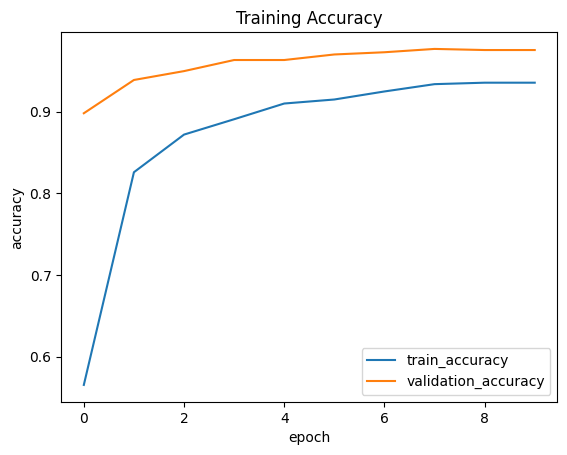

In [20]:
plt.title("Training Accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "validation_accuracy"], loc="best")
plt.show()

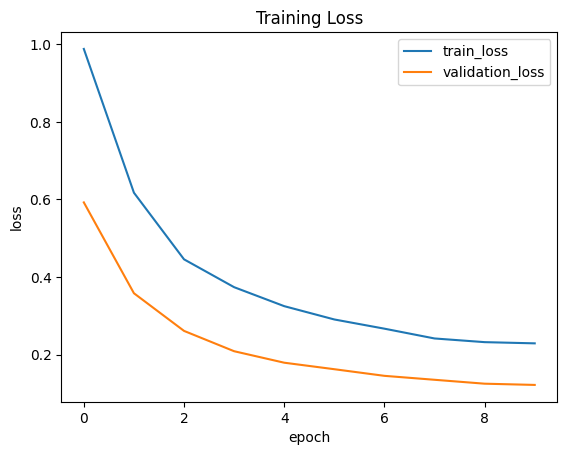

In [21]:
plt.title("Training Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", 'validation_loss'], loc="best")
plt.show()

In [22]:
# loading the best trained model
K.clear_session()
model_best = load_model("model/best_model.hdf5", compile=False)

1/1 [==============================] - 3s 3s/step


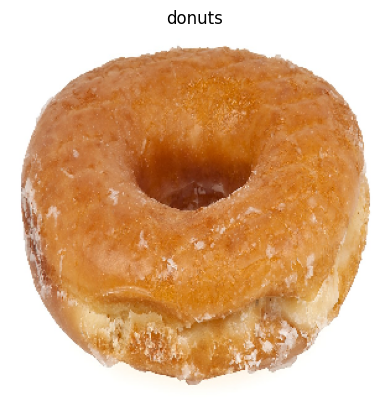

In [23]:
test_img = "donut.jpg"
img = image.load_img(test_img, target_size=(299, 299))
img = image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.                                      

pred = model.predict(img)
index = np.argmax(pred)
food_list.sort()
pred_value = food_list[index]

plt.imshow(img[0])                           
plt.axis('off')
plt.title(pred_value)
plt.show()

The model guessed the image correctly.